# Step2_Preprocessing_and_Datasets

# PART 1 – Imports & Global Settings

In [1]:
# ==================== PART 1: Imports & Settings ====================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths (adjust only if you changed folder names)
SPLITS_ROOT = "splits"   # from Step 1

Using device: cpu


# PART 2 – Define Transforms (Modality-Specific + Strong Augmentation)

In [2]:
# ==================== PART 2: Transforms (Best Practice 2025) ====================
def get_transforms(modality, phase="train"):
    """
    modality: 'mri', 'ct', or 'pet'
    phase: 'train', 'val', or 'test'
    """
    # Base size – ResNet expects 224×224
    size = 224
    
    if phase == "train":
        if modality == "pet":
            # PET is low-res & grayscale → heavier augmentation
            return transforms.Compose([
                transforms.Resize((size, size), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(25),
                transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225]),
            ])
        else:
            # MRI & CT – strong but realistic augmentation
            return transforms.Compose([
                transforms.Resize((size+32, size+32)),  # slightly larger then crop
                transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.3, contrast=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225]),
            ])
    
    else:  # val / test → only resize + normalize (NO augmentation)
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]),
        ])

# Quick test
print("Transforms defined – modality-specific + strong augmentation ready")

Transforms defined – modality-specific + strong augmentation ready


# PART 3 – Custom Dataset Class (Handles both Binary & Multiclass)

In [3]:
# ==================== PART 3: Custom Dataset Class ====================
class BrainTumorDataset(Dataset):
    def __init__(self, modality, split="train", task="binary", transform=None):
        """
        modality : 'mri', 'ct', 'pet'
        split    : 'train', 'val', 'test'
        task     : 'binary' (Tumor vs Healthy) or 'multiclass' (Glioma/Meningioma/Pituitary)
        """
        self.modality = modality
        self.split = split
        self.task = task
        self.transform = transform
        
        base_path = Path(SPLITS_ROOT) / modality / split
        
        self.samples = []
        
        # Healthy → label 0
        healthy_path = base_path / "Healthy"
        if healthy_path.exists():
            for img_path in healthy_path.glob("*.*"):
                if img_path.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}:
                    self.samples.append((str(img_path), 0))
        
        # Tumor classes
        tumor_path = base_path / "Tumor"
        if tumor_path.exists():
            if task == "binary":
                # All tumor subtypes → label 1
                for subtype_folder in tumor_path.iterdir():
                    if subtype_folder.is_dir():
                        for img_path in subtype_folder.glob("*.*"):
                            if img_path.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}:
                                self.samples.append((str(img_path), 1))
            else:  # multiclass
                label_map = {"Glioma": 0, "Meningioma": 1, "Pituitary": 2}
                for subtype, label in label_map.items():
                    folder = tumor_path / subtype
                    if folder.exists():
                        for img_path in folder.glob("*.*"):
                            if img_path.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}:
                                self.samples.append((str(img_path), label))
        
        print(f"{modality.upper()} {split.upper()} ({task}) → {len(self.samples)} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new("RGB", (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# PART 4 – Create All Datasets & DataLoaders

In [4]:
# ==================== PART 4 (FIXED + COMPLETE) ====================
batch_size = 32

# ADD THESE TWO LINES (they were accidentally missing after restart)
modalities = ['mri', 'ct', 'pet']
tasks = ['binary', 'multiclass']

dataloaders = {}
datasets = {}

for modality in modalities:
    for task in tasks:
        key_prefix = f"{modality}_{task}"
        
        datasets[f"{key_prefix}_train"] = BrainTumorDataset(modality=modality, split="train", task=task,
                                                          transform=get_transforms(modality, "train"))
        datasets[f"{key_prefix}_val"]   = BrainTumorDataset(modality=modality, split="val",   task=task,
                                                          transform=get_transforms(modality, "val"))
        datasets[f"{key_prefix}_test"]  = BrainTumorDataset(modality=modality, split="test",  task=task,
                                                          transform=get_transforms(modality, "test"))
        
        dataloaders[f"{key_prefix}_train"] = DataLoader(datasets[f"{key_prefix}_train"],
                                                        batch_size=batch_size, shuffle=True,
                                                        num_workers=4, pin_memory=True)
        
        dataloaders[f"{key_prefix}_val"]   = DataLoader(datasets[f"{key_prefix}_val"],
                                                        batch_size=batch_size, shuffle=False,
                                                        num_workers=0, pin_memory=True)
        dataloaders[f"{key_prefix}_test"]  = DataLoader(datasets[f"{key_prefix}_test"],
                                                        batch_size=batch_size, shuffle=False,
                                                        num_workers=0, pin_memory=True)

print("All dataloaders ready – visualization will now be instant!")

MRI TRAIN (binary) → 3529 images
MRI VAL (binary) → 442 images
MRI TEST (binary) → 442 images
MRI TRAIN (multiclass) → 3529 images
MRI VAL (multiclass) → 442 images
MRI TEST (multiclass) → 442 images
CT TRAIN (binary) → 3694 images
CT VAL (binary) → 462 images
CT TEST (binary) → 462 images
CT TRAIN (multiclass) → 3694 images
CT VAL (multiclass) → 462 images
CT TEST (multiclass) → 462 images
PET TRAIN (binary) → 64 images
PET VAL (binary) → 8 images
PET TEST (binary) → 9 images
PET TRAIN (multiclass) → 64 images
PET VAL (multiclass) → 8 images
PET TEST (multiclass) → 9 images
All dataloaders ready – visualization will now be instant!


# PART 5 – Visualise a Few Augmented Samples (Essential for Dissertation)

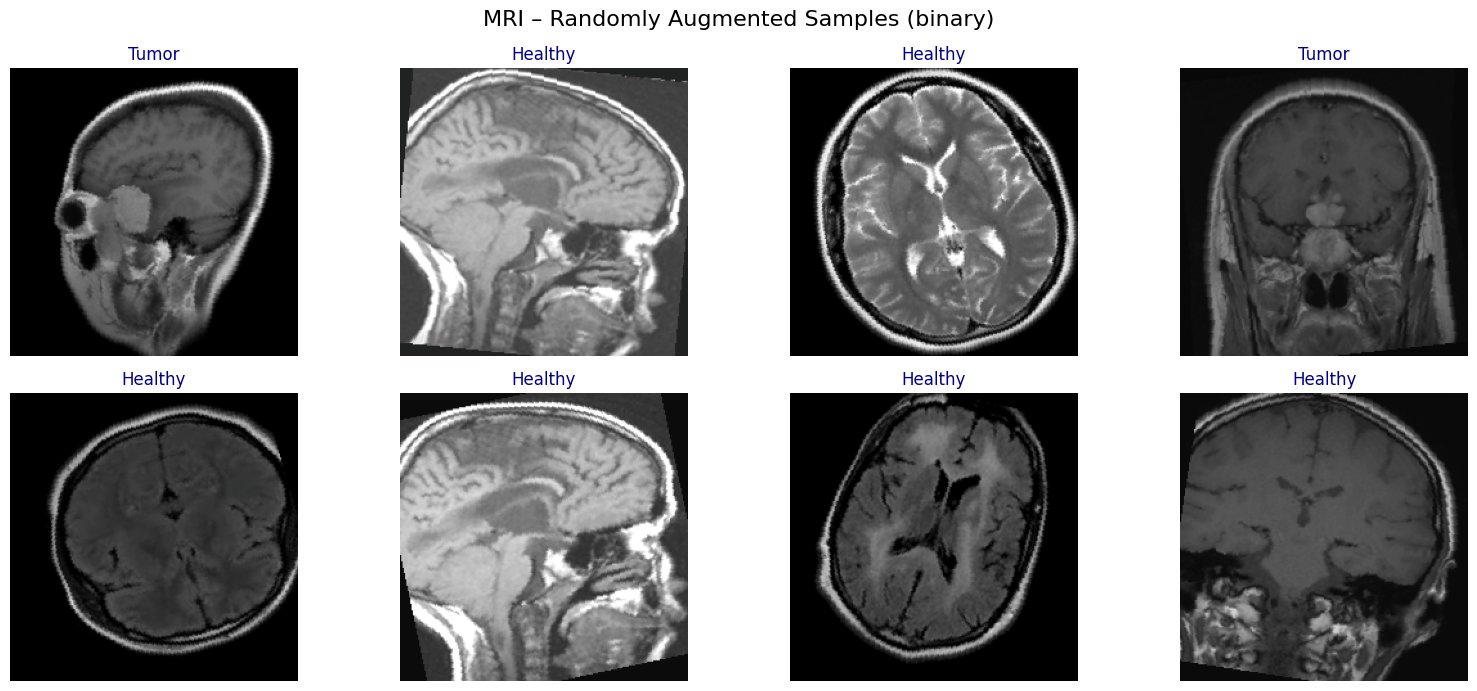

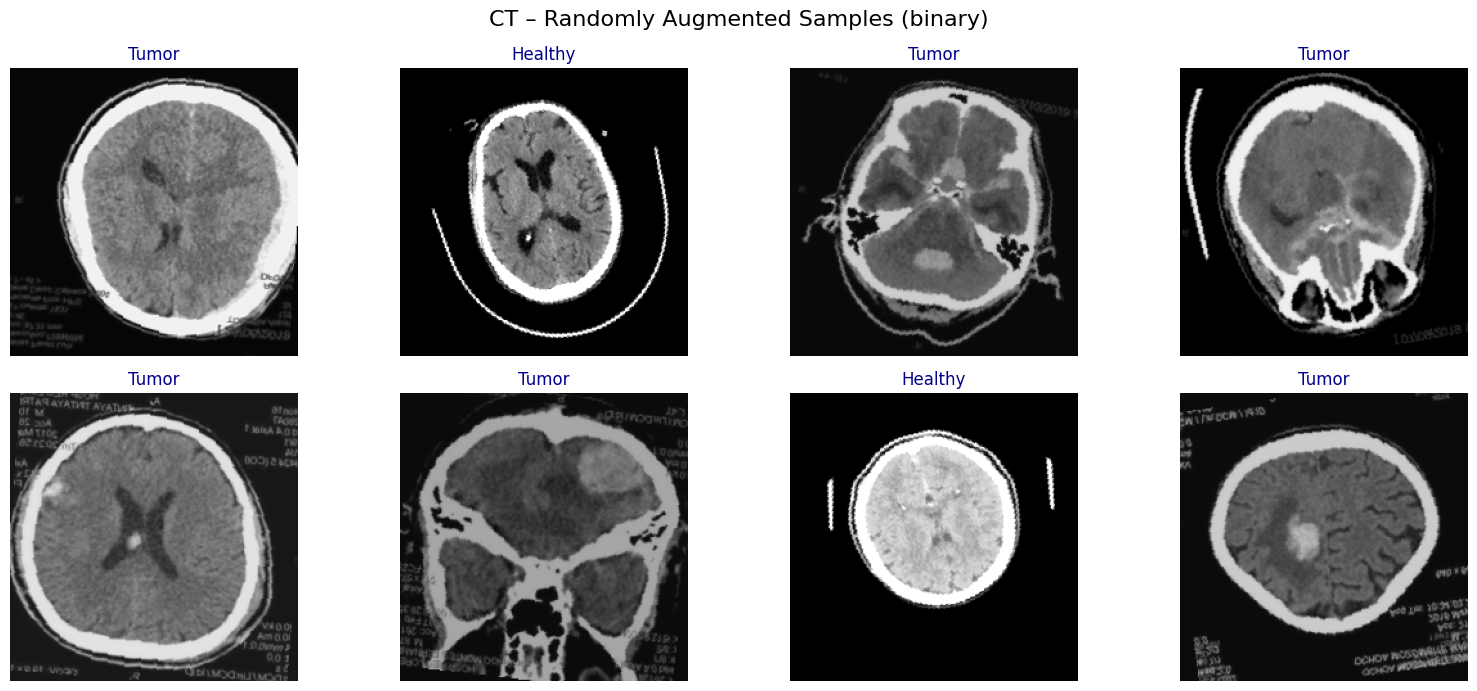

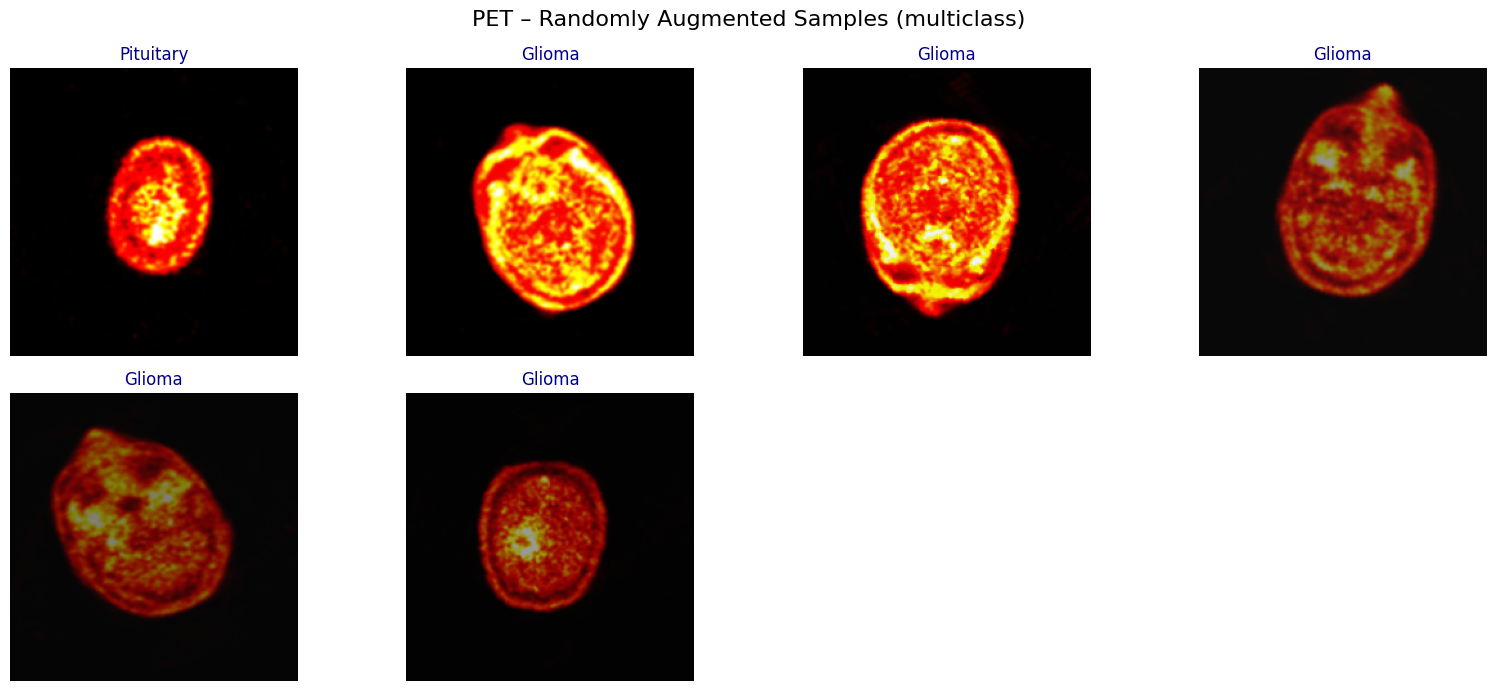

In [5]:
# PART 5 – FAST VERSION (3–5 seconds on any laptop)
def show_augmented_samples_fast(modality="mri", task="binary", n_images=8):
    # Directly use the dataset instead of DataLoader → no workers, instant
    dataset = datasets[f"{modality}_{task}_train"]
    
    plt.figure(figsize=(16, 7))
    for i in range(n_images):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]  # This applies augmentation on-the-fly
        
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.permute(1, 2, 0).clamp(0, 1)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img.numpy())
        if task == "binary":
            title = "Tumor" if label == 1 else "Healthy"
        else:
            title = ["Glioma", "Meningioma", "Pituitary"][label]
        plt.title(title, fontsize=12, color='darkblue')
        plt.axis("off")
    
    plt.suptitle(f"{modality.upper()} – Randomly Augmented Samples ({task})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run these – instant!
show_augmented_samples_fast("mri", "binary")
show_augmented_samples_fast("ct", "binary")
show_augmented_samples_fast("pet", "multiclass", n_images=6)

# PART 6 – Save Class Names for Later Use

In [6]:
# ==================== PART 6: Save Class Names ====================
class_names = {
    "binary": ["Healthy", "Tumor"],
    "multiclass": ["Glioma", "Meningioma", "Pituitary"]
}

import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f, indent=2)

print("Class names saved → class_names.json")
print("\nSTEP 2 COMPLETED 100%")
print("You now have perfect, augmented, ready-to-train PyTorch datasets for all modalities & tasks!")

Class names saved → class_names.json

STEP 2 COMPLETED 100%
You now have perfect, augmented, ready-to-train PyTorch datasets for all modalities & tasks!
